# Prediction Results with Audio Annotations on Summary Vectronics Data

**Last Modified**: Jul 29, 2025

In this notebook, we summarize and visualize the results for behavior classification with audio annotations on summary sttaistics of Vectronics acceleration data. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [18]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
import seaborn as sns
import os
import sys
from tqdm import tqdm
import json
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

sys.path.append('.')
sys.path.append('../')

from src.utils.data_prep import (combined_annotations,
                                create_max_windows,
                                create_summary_data,
                                create_data_splits,
                                adjust_behavior_and_durations,
                                setup_dataloaders,)

from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)

from src.methods.prediction_model import (SimpleNN)

from src.utils.io import (get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                          get_project_root,
                          get_results_dir,
                          )

from config.settings import (SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_W_TROTTING,
                             SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING,
                             SUMMARY_BEHAVIORS_W_TROTTING,
                             SUMMARY_BEHAVIORS_WO_TROTTING,
                             SAMPLING_RATE,
                             id_mapping
                             )
from config.paths import (HISTORIC_ACC)
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [20]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = False

In [21]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = combined_annotations(video_path=get_video_labels_path(), 
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

all_annotations.Timestamp_start = pd.to_datetime(all_annotations.Timestamp_start)
all_annotations.Timestamp_end = pd.to_datetime(all_annotations.Timestamp_end)
all_annotations['duration'] = (all_annotations.Timestamp_end - all_annotations.Timestamp_start).dt.total_seconds()

In [22]:
print(all_annotations["duration"].describe())
value = 30
quantile = np.mean(all_annotations["duration"] <= value)
print(f"Value {value}s is approximately at the {quantile*100:.2f}th percentile.")

count    12390.000000
mean        37.909282
std        113.595392
min          0.000000
25%          3.000000
50%          8.000000
75%         25.000000
max       2834.000000
Name: duration, dtype: float64
Value 30s is approximately at the 75.83th percentile.


In [23]:
metadata = pd.read_csv(get_metadata_path())

In [24]:
training_results_dir = os.path.join(get_results_dir(), 'training_results')
os.makedirs(training_results_dir, exist_ok=True)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
feature_cols = [
    'acc_x_ptp_max', 'acc_x_ptp_mean', 'acc_x_mean',
    'acc_y_ptp_max', 'acc_y_ptp_mean','acc_y_mean',
    'acc_z_ptp_max', 'acc_z_ptp_mean', 'acc_z_mean',
]

In [7]:
from dataclasses import dataclass, field
from typing import  List

@dataclass
class TrainArgs:
    batch_size: int = 32
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [64])
    dropout_rate: float = 0.5

@dataclass
class DataArgs:
    min_duration: float = 30.0

train_args = TrainArgs()
model_args = ModelArgs()
data_args = DataArgs()

## 1. Without Trotting

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(SUMMARY_BEHAVIORS_WO_TROTTING)

LabelEncoder()

In [22]:
min_durations_list = [1, 10, 20, 30]
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for min_duration in min_durations_list:

    data_args.min_duration = min_duration
    # read acceleration data
    data_path = os.path.join(get_project_root(), 'data', f"duration{min_duration}", "matched_acc_data.csv")
    metadata_path = os.path.join(get_project_root(), 'data', f"duration{min_duration}", "matched_acc_metadata.csv")

    acc_data = pd.read_csv(data_path)
    acc_data_metadata = pd.read_csv(metadata_path)
    
    acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
    acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
    acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

    acc_data = adjust_behavior_and_durations(acc_data, SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING, SUMMARY_BEHAVIORS_WO_TROTTING)
    acc_data_metadata = acc_data_metadata.loc[acc_data.index]

    acc_data.reset_index()
    acc_data_metadata.reset_index()
    
    # split it in min_duration chunks
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=30, sampling_rate=SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]

    # create summary statistics data
    split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

    # create train, val, and test splits
    X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(acc_data_split, feature_cols=feature_cols)

    for theta in theta_list:

        train_args.theta = theta

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS_WO_TROTTING), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{train_args.theta}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

Epoch 100/100 | Train Loss: 0.0363 | Val Loss: 0.0371 | Best val Loss: 0.0365: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


Total training time: 0:00:57


Epoch 100/100 | Train Loss: 0.0537 | Val Loss: 0.0363 | Best val Loss: 0.0347: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Total training time: 0:00:58


Epoch 100/100 | Train Loss: 0.0676 | Val Loss: 0.0388 | Best val Loss: 0.0378: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


Total training time: 0:00:56


Epoch 100/100 | Train Loss: 0.0684 | Val Loss: 0.0452 | Best val Loss: 0.0411: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Total training time: 0:00:58


Epoch 100/100 | Train Loss: 0.0745 | Val Loss: 0.0501 | Best val Loss: 0.0491: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Total training time: 0:00:58


Epoch 100/100 | Train Loss: 0.0775 | Val Loss: 0.0609 | Best val Loss: 0.0567: 100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Total training time: 0:00:58


Epoch 100/100 | Train Loss: 0.1045 | Val Loss: 0.1023 | Best val Loss: 0.1017: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1348 | Val Loss: 0.1045 | Best val Loss: 0.1029: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1603 | Val Loss: 0.1100 | Best val Loss: 0.1091: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1740 | Val Loss: 0.1208 | Best val Loss: 0.1157: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1820 | Val Loss: 0.1317 | Best val Loss: 0.1247: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1843 | Val Loss: 0.1440 | Best val Loss: 0.1393: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1312 | Val Loss: 0.1166 | Best val Loss: 0.1146: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1532 | Val Loss: 0.1162 | Best val Loss: 0.1148: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1754 | Val Loss: 0.1227 | Best val Loss: 0.1211: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1905 | Val Loss: 0.1305 | Best val Loss: 0.1298: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.2032 | Val Loss: 0.1405 | Best val Loss: 0.1405: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.2027 | Val Loss: 0.1736 | Best val Loss: 0.1569: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1277 | Val Loss: 0.1222 | Best val Loss: 0.1213: 100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Total training time: 0:01:15


Epoch 100/100 | Train Loss: 0.1571 | Val Loss: 0.1244 | Best val Loss: 0.1235: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1790 | Val Loss: 0.1340 | Best val Loss: 0.1298: 100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1921 | Val Loss: 0.1408 | Best val Loss: 0.1380: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.2008 | Val Loss: 0.1572 | Best val Loss: 0.1504: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.2022 | Val Loss: 0.1845 | Best val Loss: 0.1720: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]

Total training time: 0:01:12


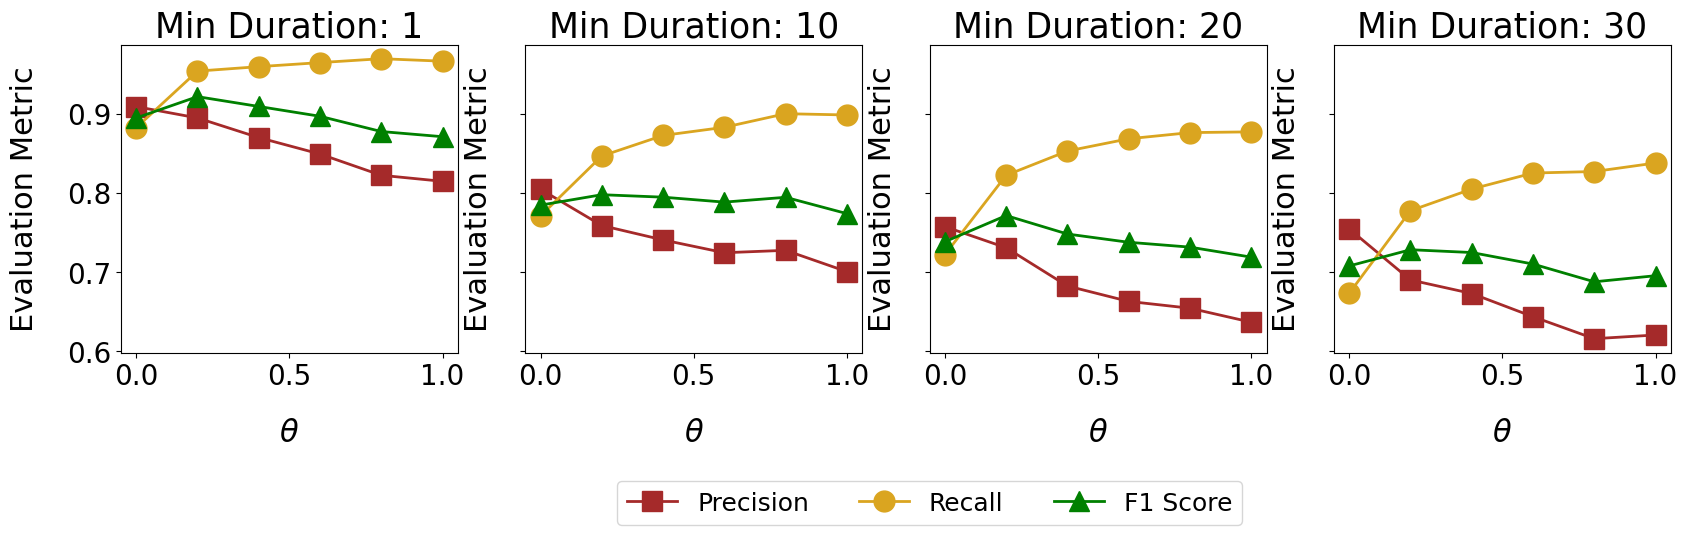

In [26]:
fig, axs = plt.subplots(1, len(min_durations_list), figsize=(5*len(min_durations_list), 4), sharey=True)
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

for i, min_duration in enumerate(min_durations_list):
    for j, theta in enumerate(theta_list):

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")

        precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

    axs[i].plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
    axs[i].plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
    axs[i].plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
    axs[i].set_title(f"Min Duration: {min_duration}")
    axs[i].set_xlabel(r'$\theta$', labelpad=20)
    axs[i].set_ylabel('Evaluation Metric', labelpad=20)

axs[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(2.4,-0.6))
# plt.tight_layout()
plt.show()  

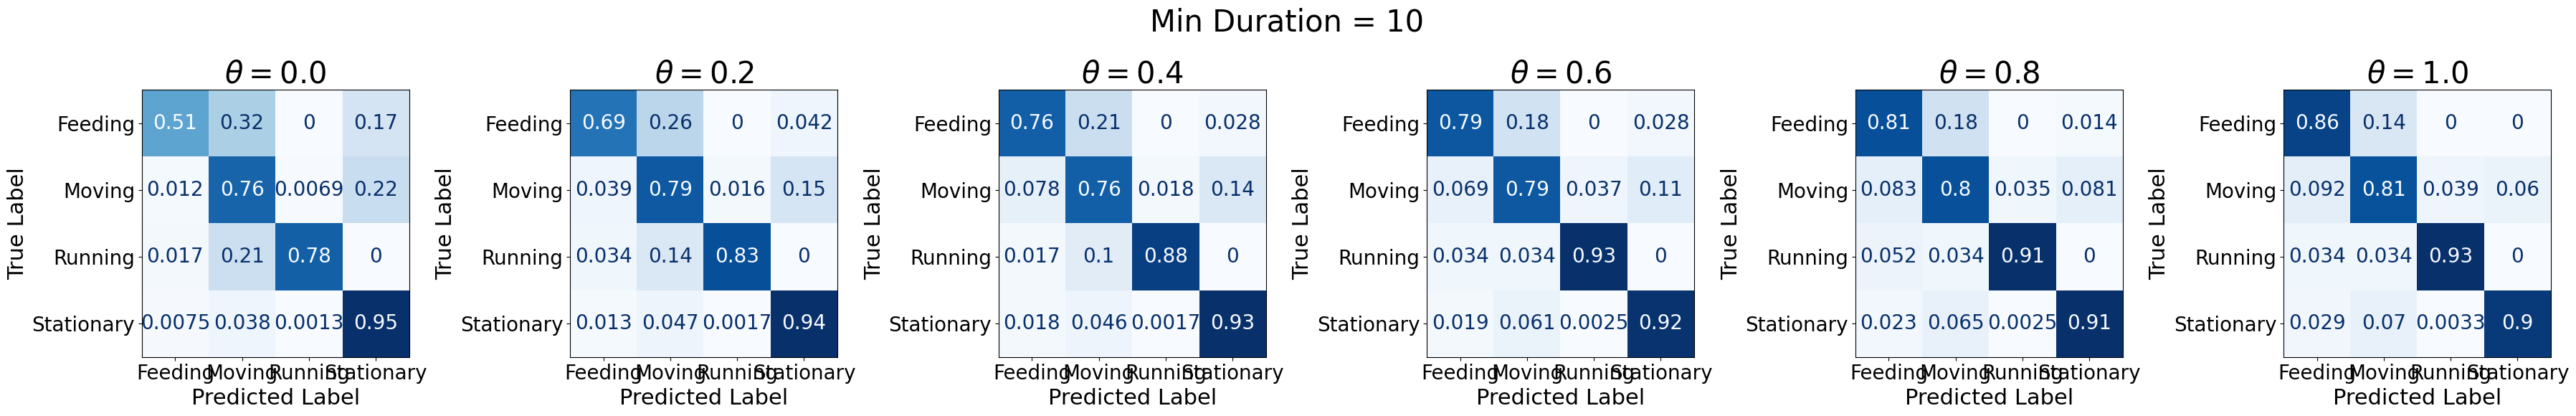

In [28]:
min_duration = 10

fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 6))

for i, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_, 
    )
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)

    # Optional: format text size
    for text in disp.text_.ravel():
        text.set_fontsize(20)

    axs[i].set_title(f"$\\theta = {theta}$", fontsize=30)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

fig.suptitle(f"Min Duration = {min_duration}", fontsize=30)
plt.tight_layout()
plt.show()

## 2. With Trotting

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(SUMMARY_BEHAVIORS_W_TROTTING)
min_durations_list = [1, 10, 20, 30]
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [ ]:


for min_duration in min_durations_list:

    data_args.min_duration = min_duration
    # read acceleration data
    data_path = os.path.join(get_project_root(), 'data', f"duration{min_duration}", "matched_acc_data.csv")
    metadata_path = os.path.join(get_project_root(), 'data', f"duration{min_duration}", "matched_acc_metadata.csv")

    acc_data = pd.read_csv(data_path)
    acc_data_metadata = pd.read_csv(metadata_path)
    
    acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
    acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
    acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

    acc_data = adjust_behavior_and_durations(acc_data, SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_W_TROTTING, SUMMARY_BEHAVIORS_W_TROTTING)
    acc_data_metadata = acc_data_metadata.loc[acc_data.index]

    acc_data.reset_index()
    acc_data_metadata.reset_index()
    
    # split it in min_duration chunks
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=30, sampling_rate=SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]

    # create summary statistics data
    split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

    # create train, val, and test splits
    X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(acc_data_split, feature_cols=feature_cols)

    for theta in theta_list:

        train_args.theta = theta

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS_W_TROTTING), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{train_args.theta}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])

Epoch 100/100 | Train Loss: 0.0321 | Val Loss: 0.0369 | Best val Loss: 0.0365: 100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


Total training time: 0:01:00


Epoch 100/100 | Train Loss: 0.0546 | Val Loss: 0.0384 | Best val Loss: 0.0376: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Total training time: 0:00:59


Epoch 100/100 | Train Loss: 0.0677 | Val Loss: 0.0425 | Best val Loss: 0.0415: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Total training time: 0:00:59


Epoch 100/100 | Train Loss: 0.0691 | Val Loss: 0.0488 | Best val Loss: 0.0469: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Total training time: 0:00:59


Epoch 100/100 | Train Loss: 0.0773 | Val Loss: 0.0553 | Best val Loss: 0.0511: 100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


Total training time: 0:00:58


Epoch 100/100 | Train Loss: 0.0850 | Val Loss: 0.0709 | Best val Loss: 0.0687: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Total training time: 0:00:58


Epoch 100/100 | Train Loss: 0.1036 | Val Loss: 0.0931 | Best val Loss: 0.0927: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1289 | Val Loss: 0.0934 | Best val Loss: 0.0923: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1512 | Val Loss: 0.0986 | Best val Loss: 0.0967: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1679 | Val Loss: 0.1054 | Best val Loss: 0.1010: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1792 | Val Loss: 0.1159 | Best val Loss: 0.1112: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Total training time: 0:01:12


Epoch 100/100 | Train Loss: 0.1815 | Val Loss: 0.1359 | Best val Loss: 0.1291: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:12


Epoch 100/100 | Train Loss: 0.1142 | Val Loss: 0.1052 | Best val Loss: 0.1047: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1416 | Val Loss: 0.1064 | Best val Loss: 0.1061: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1654 | Val Loss: 0.1142 | Best val Loss: 0.1099: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Total training time: 0:01:12


Epoch 100/100 | Train Loss: 0.1872 | Val Loss: 0.1198 | Best val Loss: 0.1181: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.2044 | Val Loss: 0.1361 | Best val Loss: 0.1281: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


Total training time: 0:01:12


Epoch 100/100 | Train Loss: 0.2016 | Val Loss: 0.1618 | Best val Loss: 0.1495: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1183 | Val Loss: 0.1123 | Best val Loss: 0.1121: 100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


Total training time: 0:01:14


Epoch 100/100 | Train Loss: 0.1575 | Val Loss: 0.1116 | Best val Loss: 0.1115: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1847 | Val Loss: 0.1190 | Best val Loss: 0.1161: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.1981 | Val Loss: 0.1258 | Best val Loss: 0.1242: 100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


Total training time: 0:01:12


Epoch 100/100 | Train Loss: 0.2104 | Val Loss: 0.1416 | Best val Loss: 0.1347: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


Total training time: 0:01:13


Epoch 100/100 | Train Loss: 0.2161 | Val Loss: 0.1657 | Best val Loss: 0.1552: 100%|██████████| 100/100 [01:12<00:00,  1.38it/s]

Total training time: 0:01:13


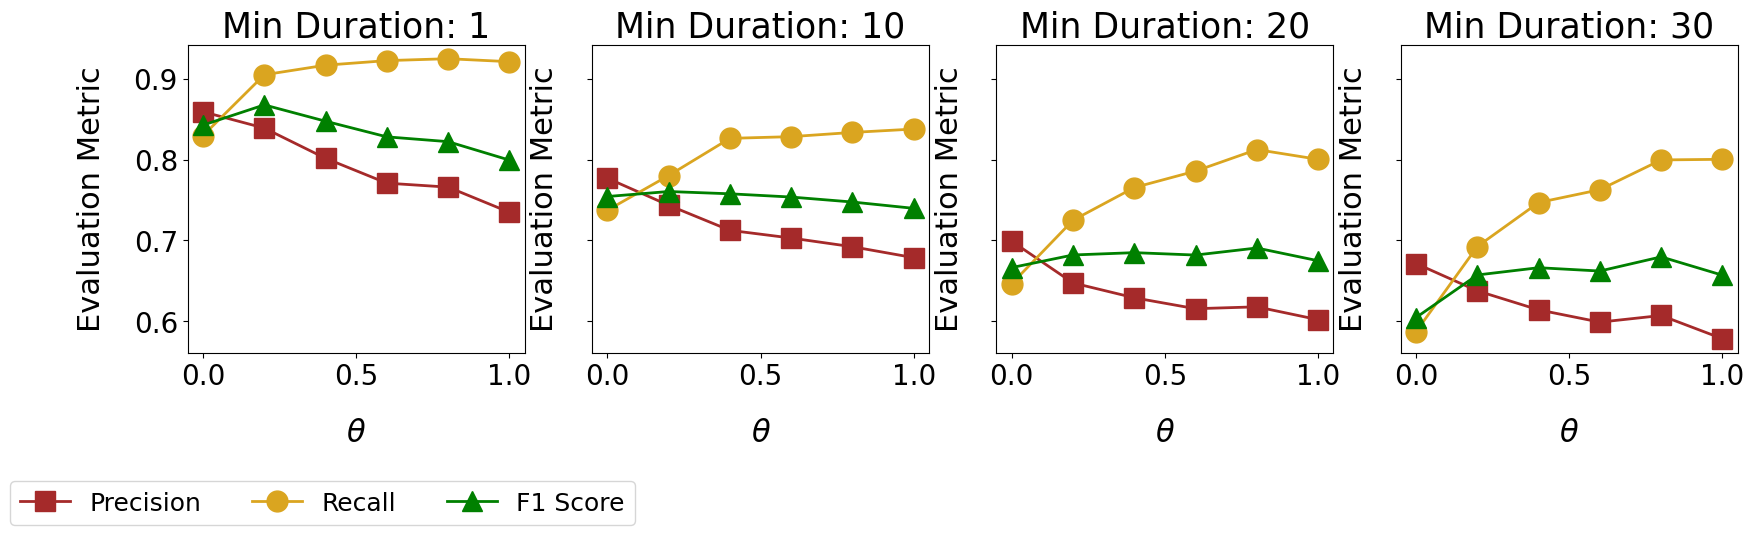

In [12]:
fig, axs = plt.subplots(1, len(min_durations_list), figsize=(5*len(min_durations_list), 4), sharey=True)
colors = ['brown', 'goldenrod', 'green']

precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

for i, min_duration in enumerate(min_durations_list):
    for j, theta in enumerate(theta_list):

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")

        precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

    axs[i].plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
    axs[i].plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
    axs[i].plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
    axs[i].set_title(f"Min Duration: {min_duration}")
    axs[i].set_xlabel(r'$\theta$', labelpad=20)
    axs[i].set_ylabel('Evaluation Metric', labelpad=20)

axs[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(0.4,-0.6))
# plt.tight_layout()
plt.show()  

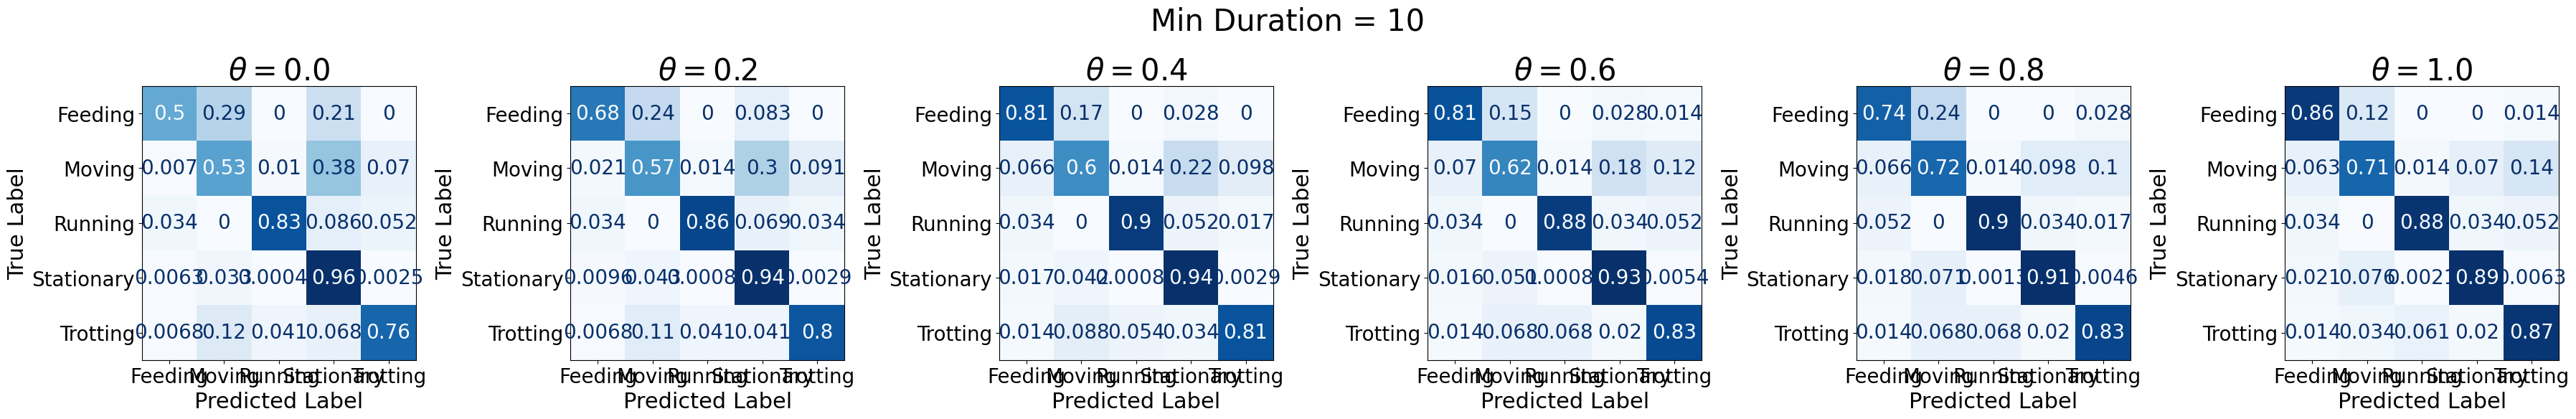

In [13]:
min_duration = 10

fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 6))

for i, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_, 
    )
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)

    # Optional: format text size
    for text in disp.text_.ravel():
        text.set_fontsize(20)

    axs[i].set_title(f"$\\theta = {theta}$", fontsize=30)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

fig.suptitle(f"Min Duration = {min_duration}", fontsize=30)
plt.tight_layout()
plt.show()